# Predicting What Section a NYT Article is From Using a Naive Bayes Classifier

### By Derek Sawicki


## Introduction
In this notebook, I attempt a solution to this exercise, found on page 109 of the book Doing Data Science, by Rachel Schutt and Cathy O’Neil.
>First, you will use the <i>New York Times</i> Developer API to fetch recent articles from several sections of the Times. Then, using the simple Bernoulli model for word presence, you will implement a classifier which, given the text of an article from the New York Times, predicts the section to which the article belongs.
   
This being my first data science project of this scale, my goal was to become a little more familiar with the data science process, as well as getting a sense of how and when to use a Naive Bayes algorithm.

## The approach used
I use the NYT API to gather data for 2000 articles. Ideally, the entire contents of each article would be used to train the model, but the API doesn't allow for that. I use what I believe is the next best thing - a snippet from the lead paragraph. I could have included the text from the headline, as the headline and url of each article are also stored for the sake of the exercise, but it appeared to me that that would have been mostly redundant. Of course, something like that should be tested, but my aim here isn't thoroughness.

The frequencies of words in each snippet are used to construct a feature matrix where each column represents a single word. The value of each entry is an integer indicating how many times a certain word appears in an article. The target is the section the article belongs to.  

## Setup

In [78]:
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import json

from nltk.corpus import stopwords
import re
import string
from collections import Counter
from time import sleep

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit



## Mining the data using the NYT API
As per the instructions in the exercise, I only grab articles that belong to the Arts, Business, Obituaries, Sports, or World sections. The API has a 5 second limit between requests, so this part can take quite a while. I store the url, headline, and lead_paragraph elements for each article in 1 of 5 .csv's, corresponding to the five sections.

To follow along you'll need to [register for a <i>New York Times</i> Developer API Key](https://developer.nytimes.com/) and request access to
the Article Search API.

In [35]:
APIKEY = open('apikey.txt').read()

def getWords(snippet):
    if type(snippet) is not str:
        return []
    
    # Clean the words
    snippet = snippet.replace(u"\u2018", "").replace(u"\u2019", "").replace(u"\u201c","").replace(u"\u201d", "")
    snippet = re.sub('['+string.punctuation+']', '', snippet.lower())
    
    # Translate to list of words
    words = snippet.split()
    
    # remove stop words
    ret = [ x for x in words if x not in stopwords.words('english') ]
    return ','.join(ret)
 
    

# Stores the url, headline, and a snippet of 2000 recent NYT articles in csv files, separated
# by section_name.
section_map = {'Arts': 0,
                'Business': 1,
                'Obituaries': 2,
                'Sports': 3,
                'World': 4
                }
for section in section_map.keys():
    print ("loading section", section)
    urls = []
    headlines = []
    word_lists = []
    section_ = []

    # Get 20*10=200 articles from each section
    for page in range (40):
        
        # There is a 5 second limit on requests, I sleep for 7 seconds out of kindess
        sleep(7)
        
        
        # Request the most recent articles in this section
        req = ("http://api.nytimes.com/svc/search/v2/articlesearch.json?fq=section_name:(\'"
        +section+"\')&page="+str(page)+"&fl=web_url,abstract,lead_paragraph,lead_paragraph,headline,section_name&api-key="
        +APIKEY)
        
        # Catch exceptions. 
        try:
            result = urlopen(req)
        except HTTPError as e:
            print("exception: ", e.code)
            continue
        except URLError as e:
            print ("exception:", e.reason)
            continue
            
        # Parse result into dataframe ready lists
        jsonObj = json.loads(result.read())
        docs = jsonObj.get('response').get('docs')
        for article in docs:
            urls.append(article.get('web_url'))
            hl = article.get('headline').get('main')
            hl = hl.replace(u"\u2018", "").replace(u"\u2019", "").replace(u"\u201c","").replace(u"\u201d", "")
            headlines.append(hl)
            word_lists.append(getWords(article.get('lead_paragraph')))
            section_.append(section_map[section])

    # Store in dataframe
    raw_data = {
        'url': urls,
        'headline': headlines,
        'word_list': word_lists,
        'section': section_
        }
    df = pd.DataFrame(raw_data, columns = ['url', 'headline', 'word_list', 'section'])

    # Save dataframe to a file
    filename = section+'.csv'
    df.to_csv(filename, sep=',')

## Creating the feature matrix
Now I use those databases to construct a feature matrix where each column represents one word, and each entry holds the number of times that words occurs in the artle represented by a row.

The word list is chosen by the most frequent k words from each section. I made k a parameter because I was curious about how it would effect accuracy. I thought about filtering out words that were common between sections, but haven't got around to trying that yet.

In [80]:
# Need to determine the vocabulary to construct the feature vector

# Discovers which k words are most frequent from each section, and compiles them into one
# list.
def DiscoverFeatures(k):
    vocab = []
    for section in ['Arts', 'Business', 'Obituaries', 'Sports', 'World']:
        filename = section+'.csv'
        df = pd.read_csv(filename, encoding='latin-1')
        df = df.loc[:, ['word_list']]

        all_words = []
        for i, row in df.iterrows():
            if type(row['word_list']) is str:
                for word in row['word_list'].split(','):
                    all_words.append(word)

        vocab.extend(  list(dict(Counter(all_words).most_common(k)).keys()) )

    return vocab


def ConstructFeatureVector(vocab):
    combinedData = pd.DataFrame()

    # Gather all the data into one dataframe
    for section in ['Arts', 'Business', 'Obituaries', 'Sports', 'World']:
        filename = section+'.csv'
        df = pd.read_csv(filename, encoding='latin-1')
        df = df.loc[:, ['word_list', 'section']]
        combinedData = pd.concat([combinedData, df])
        combinedData.reset_index()

    rows = []
    for i,row in combinedData.iterrows(): # For each example
        featureVector = [ 0 for i in range(len(vocab))]

        for word in range(len(vocab)): # For every word in the feature vector
            if type(row['word_list'])is str:
                if vocab[word] in row['word_list']:
                    featureVector[word] = row['word_list'].count(vocab[word])
            else:
                continue
        rows.append(featureVector)
    X = pd.DataFrame(rows)
    return X, combinedData['section']


In [57]:

def RunNaiveBayes(X, y):
    #y = combinedData['section']

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0, train_size = 0.6)

    bernoulli = BernoulliNB(binarize=0.5)
    multinomial = MultinomialNB()

    bernoulli.fit(X_train, y_train)
    multinomial.fit(X_train, y_train)

    bern = bernoulli.score(X_test, y_test)
    mult = multinomial.score(X_test, y_test)
    
    return bern, mult




## Parameter Testing
Next I see what size k of the feature list produces the best score. It looks that the best score for both
estimators is achieved at around k=175. 

In [95]:
# Create a graph of size of vocab vs accuracy over all examples
bernScore = []
multScore = []
K = range(30,300,30)
for k in K:
    features = DiscoverFeatures(k)
    X, y = ConstructFeatureVector(vocab=features)
    
    b,m = RunNaiveBayes(X, y)
    bernScore.append(b)
    multScore.append(m)


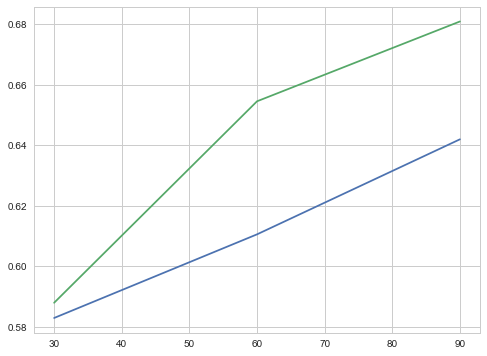

In [94]:
# make this plot look nicer, add legend and labels
plt.figure(figsize=(8,6))
plt.plot(K, bernScore)
plt.plot(K, multScore)

## Plotting learning curves


In [93]:
# Looks like 170 is good for multinomialNB, and 150 is good for bernoulliNB

import warnings
warnings.simplefilter("ignore")

def plotLearningCurve(estimator, X, y):
    plt.figure(figsize=(8,6))
    plt.title("Learning Curve")
    plt.xlabel("N Training Examples")
    plt.ylabel("Score")
    plt.grid()
    train_sizes_abs, train_scores, test_scores = learning_curve(estimator, X, y)
    plt.plot(train_sizes_abs, train_scores, label="Training score")
    plt.plot(train_sizes_abs, test_scores, label="Test score")
    
    
features = DiscoverFeatures(170)
X, y = ConstructFeatureVector(vocab=features)

KeyboardInterrupt: 

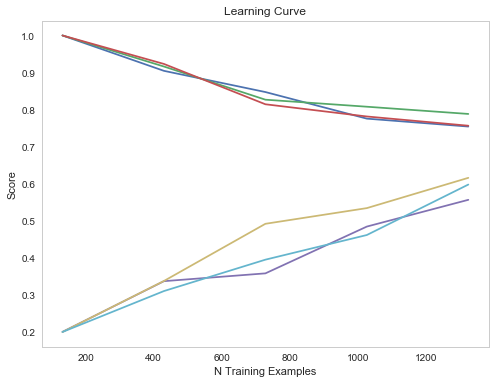

In [91]:
plotLearningCurve(BernoulliNB(binarize=0.5), X, y)


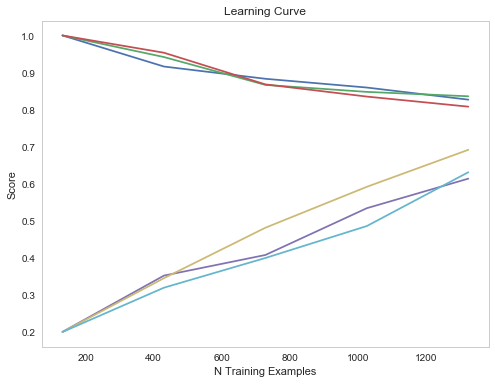

In [92]:
plotLearningCurve(MultinomialNB(), X, y)

## Conclusion
This learning curves look to reveal a case of high bias, which means that even with more data, the score capping the score around 0.7 and 0.8 for bernoulliNB and multinomialNB, respectively. To attempt to correct the under-fitting, I would try changing the way the words for the feature vector are chosen. Currently, words are picked from each section and joined together. It might be a better idea to filter out words that are common between sections.
